In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/Tiny shakespeare/input.txt")

In [3]:
with open(data_dir, 'r') as f:
    text = f.read()

In [4]:
vocab = sorted(list(set(text)))
vocab_size = len(sorted(list(set(text)))) 
data_size = len(text)
# Hyperparameters
batch_size = 100 #B
block_size = 300 #T
emb_size = 512 #C
num_blocks = 4
num_heads = 8
head_size = 512
dropout = 0.2

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [5]:
token_encodings = {}
token_decodings = {}
for i, token in enumerate(vocab):
    token_encodings[token] = i
    token_decodings[i] = token

In [6]:
def encode(txt):
    enc_char = [token_encodings[char] for char in txt]
    return enc_char

def decode(enc_tokens):
    dec_char = [token_decodings[idx] for idx in enc_tokens]
    decoded_str = "".join(dec_char)
    return decoded_str

def generate_batch(batch_size, block_size):
    idx = torch.randint(0, data_size - block_size - 1, (batch_size,))
    data = torch.tensor(
        [encode(text[i : i + block_size]) for i in idx], device=device
    ) # B x T 
    targets = torch.tensor(
        [encode(text[i + 1 : i + block_size + 1]) for i in idx], device=device
    ) # B x T 
    return data, targets

In [7]:
data, targets = generate_batch(batch_size, block_size)
# print([decode(data[i].cpu().numpy()) for i in range(data.shape[0])])

In [8]:
class ShakespeareDataset(Dataset):
    def __init__(self, data_dir, train=True):
        super().__init__()
        self.data = open(data_dir, 'r').read()
        train_dataset, val_dataset = torch.utils.data.random_split(self.data, [int(len(self.data) * 0.8), len(self.data) - int(len(self.data) * 0.8)])
        if train:
            self.dataset = train_dataset
        else:
            self.dataset = val_dataset
    
    def __getitem__(self, idx):
        # idx = torch.randint(0, data_size - block_size - 1, (batch_size,))
        data = torch.tensor(
            [encode(self.dataset[i : i + block_size]) for i in idx], device=device
        ) # B x T 
        targets = torch.tensor(
            [encode(self.dataset[i + 1 : i + block_size + 1]) for i in idx], device=device
        ) # B x T 
        return data, targets
    
    def __len__(self):
        return len(self.dataset)

In [9]:
dataset = ShakespeareDataset(data_dir)
sampler = DistributedSampler(dataset, num_replicas=1, rank=0)
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size
        self.q = nn.Linear(emb_size, self.head_size, device=device)
        self.k = nn.Linear(emb_size, self.head_size, device=device)
        self.v = nn.Linear(emb_size, self.head_size, device=device)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        q = self.q(x) # B, T, C -> B, T, H
        k = self.k(x)
        v = self.v(x)
        B, T, H = q.shape
        wei = q @ k.transpose(-1, -2) / np.sqrt(self.head_size) # B, T, H @ B, H, T -> B, T, T
        # print(wei.shape)
        mask = torch.tril(torch.ones(B, T, T)).to(device)
        wei = wei.masked_fill(mask == 0, float('-inf'))
        wei = nn.functional.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v # B, T, H  
        return out

In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, emb_size):
        super().__init__()
        self.n_heads = n_heads
        self.emb_size = emb_size
        self.head_size = emb_size // n_heads
        self.linear = nn.Sequential(nn.Linear(emb_size,4 * emb_size), nn.ReLU(), nn.Linear(4 * emb_size, emb_size), nn.Dropout(0.2),)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = []
        for i in range(self.n_heads):
            att_head = SelfAttention(self.head_size)
            out.append(att_head(x))
        # print(len(out), out[0].shape)
        logits = torch.cat(out, dim=-1)
        logits = self.linear(logits)
        return logits


In [12]:
class FeedForwardBlock(nn.Module):
    def __init__(self, num_blocks, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.mha = MultiHeadedAttention(num_heads, emb_size)
        self.ff_net = nn.Sequential(
            nn.Linear(emb_size, emb_size * 4),
            nn.ReLU(),
            nn.Linear(emb_size * 4, emb_size),
            nn.Dropout(dropout)
        )
        self.layer_norm_1 = nn.LayerNorm(emb_size)
        self.layer_norm_2 = nn.LayerNorm(emb_size)

    def forward(self, x):
        x = x + self.mha(self.layer_norm_1(x)) # B, T, C
        x = x + self.ff_net(self.layer_norm_2(x)) # B, T, vocab_size
        return x
        

In [13]:
class GPT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb_table = nn.Embedding(vocab_size, emb_size, device=device)
        self.pos_emb_table = nn.Embedding(block_size, emb_size, device=device)
        # self.ff_net = nn.Linear(emb_size, emb_size, device=device)
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.head_size = head_size
        # self.mha = MultiHeadedAttention(self.num_heads)
        # self.layer_norm = nn.LayerNorm(emb_size, device=device, dtype=torch.float32)
        self.final_ll = nn.Linear(emb_size, vocab_size, device=device)
        self.blocks = nn.Sequential(
            *[FeedForwardBlock(num_blocks, num_heads) for i in range(num_blocks)]
        )

    def forward(self, x, targets=None):
        token_emb = self.token_emb_table(x) # B, T, C
        # print(x.shape, token_emb.shape)
        pos_emb = self.pos_emb_table(torch.arange(x.shape[-1], device=device)) # T, C
        x = token_emb + pos_emb # B, T, C
#         for _ in range(num_blocks):
#             x_res = x
#             x = self.layer_norm(x)
#             x = self.mha(x) # B, T, C
# #             x = x_res + x
# #             x_res = x
#             x = x_res + self.ff_net(x) # B, T, vocab_size
        x = self.blocks(x)
        logits = self.final_ll(x)
        # print(logits.shape)
        B, T, C = logits.shape
        if targets is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            # targets = self.token_emb_table(targets)
            loss = loss_fn(logits.view(B*T, C), targets.view(B*T))
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_tokens):
        for _ in range(max_tokens):
            idx_slice = idx[:, -block_size:]
            logits, loss = self.forward(idx_slice)
            logits = logits[:, -1, :]
            probabs = nn.functional.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probabs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            
        return decode(idx[0].tolist())


    def train(self, num_steps, batch_size):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, betas=(0.9, 0.95))
        loss_ar = []
        for step in range(num_steps):
            optimizer.zero_grad()
            data, targets = generate_batch(batch_size, block_size)
            logits, loss = self.forward(data, targets)
            loss_ar.append(loss.item())
            loss.backward()
            optimizer.step()
            if (step+1) % 10 == 0:
                print(f"Step {step}, loss {loss.item()}")
        return loss_ar


In [14]:
gpt = GPT(vocab_size).to(device)

In [15]:
np.sum([p.numel() for p in gpt.parameters()])

17026113

In [22]:
logits, loss = gpt(data, targets)
generated = gpt.generate(torch.zeros((1,1), dtype=torch.long, device=device), max_tokens=60)

In [23]:
print(generated)



ANEre, thnenthyomange?
Dodith phastrambe y. isenerokllll rsh


In [29]:
loss_ar = gpt.train(3000, 1000)

RuntimeError: CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 23.64 GiB total capacity; 21.12 GiB already allocated; 326.50 MiB free; 22.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

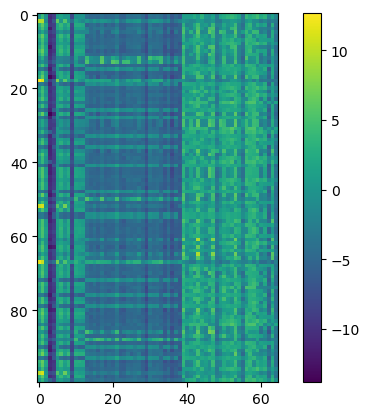

In [28]:
import matplotlib.pyplot as plt
plt.colorbar(plt.imshow(logits[:, -1, :].detach().cpu()))

In [21]:
logits

tensor([[[-2.8712, -2.8776, -5.7506,  ..., -6.7138,  2.3166, -4.2646],
         [ 2.2666,  5.8622,  1.1950,  ..., -4.8820,  4.5160, -4.6009],
         [ 0.9859,  3.7968, -0.4846,  ..., -1.4746,  3.9694,  0.1545],
         ...,
         [ 1.3278,  4.5611, -0.1112,  ..., -2.8009,  0.2636, -0.8037],
         [ 1.0038,  4.1428, -0.2047,  ..., -4.4941,  2.0864, -3.4750],
         [-0.1262,  4.1514, -0.6295,  ..., -1.7450,  1.1746, -1.7344]],

        [[ 3.6048,  5.5413,  1.3762,  ..., -5.6074,  3.2470, -3.2274],
         [ 2.3791,  5.5143,  0.8049,  ..., -4.7237,  4.0308, -4.1264],
         [ 2.4558,  5.0289,  0.5069,  ...,  0.4731,  1.9874, -3.4135],
         ...,
         [ 2.9018,  5.3309,  0.7603,  ..., -5.8284,  3.0076, -3.9101],
         [-3.5100, -2.4801, -5.1948,  ..., -5.9227,  1.7546, -3.9276],
         [ 0.3271,  4.2953, -0.6670,  ..., -1.6680,  1.0548, -1.6020]],

        [[-3.5335, -2.6660, -5.2325,  ..., -6.4373,  2.3984, -4.3265],
         [ 2.3312,  5.5282,  1.0756,  ..., -5